# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
#General demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter=';')

#Feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')

In [3]:
azdias.shape

(891221, 85)

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.öo

def replace_missing_values_with_nan(df, mapper, mapper_column_name, mapper_column_definition, non_numerical_indicators=[]):
    # For each mapper_df row definition
    for index, row in mapper.iterrows():
        # Omit rows with no NaNs or with lists without values
        if len(row[mapper_column_definition]) > 0 and row[mapper_column_definition] != ['']:
            try:
                # For each column definition
                # build a list of nan_indicators
                replace_mask = []
                for nan_indicator in row[mapper_column_definition]:
                    
                    if nan_indicator in non_numerical_indicators:
                        replace_mask.append(nan_indicator)
                    else:
                        replace_mask.append(int(nan_indicator))
                
                #print(replace_mask)
                # Replace masked values with NaN
                df[row[mapper_column_name]] = df[row[mapper_column_name]].replace(replace_mask, np.nan)
                
            except Exception as e:
                print('Exception: {} -> {} --> {}'.format(row[mapper_column_name], str(e), nan_indicator))
                continue
                
    return df

In [7]:
feat_info.missing_or_unknown = feat_info.missing_or_unknown.str.strip('[').str.strip(']').str.split(',')

In [8]:
type(feat_info.missing_or_unknown[0])

list

In [9]:
feat_info.head(20)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [10]:
# Replace with NaNs all values in all columns of azdias as per mapping in feat_info
azdias = replace_missing_values_with_nan(azdias, feat_info, 'attribute', 'missing_or_unknown', non_numerical_indicators=['X', 'XX'])

In [11]:
azdias.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AGER_TYP,NaN,NaN,NaN,2,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
ALTERSKATEGORIE_GROB,2,1,3,4,3,1,2,1,3,3,3,2,3,1,3,4,1,2,2,3
ANREDE_KZ,1,2,2,2,1,2,2,1,1,2,2,1,1,2,1,2,2,1,2,1
CJT_GESAMTTYP,2,5,3,2,5,2,5,3,3,4,1,6,6,5,6,4,1,6,6,3
FINANZ_MINIMALIST,3,1,1,4,4,3,1,3,4,2,2,3,5,1,3,4,4,3,2,5
FINANZ_SPARER,4,5,4,2,3,1,5,3,4,4,2,4,3,4,4,1,3,4,4,2
FINANZ_VORSORGER,3,2,1,5,4,5,1,4,2,2,5,3,4,3,3,5,1,3,1,3
FINANZ_ANLEGER,5,5,2,2,1,2,5,1,4,3,3,5,2,5,5,1,4,5,5,1
FINANZ_UNAUFFAELLIGER,5,4,3,1,3,2,4,3,2,5,1,5,4,5,5,1,5,5,4,3
FINANZ_HAUSBAUER,3,5,5,2,2,5,3,2,2,4,5,3,1,2,3,4,1,3,1,1


In [12]:
# Perform an assessment of how much missing data there is in each column of the dataset.

def extract_columns_with_nan(df):

    # Extract columns with NaNs
    columns_with_nans = df.isnull().sum()[df.isnull().sum() > 0]

    # Calculate percentage of NaN for each column
    dic_nan = {'sum': columns_with_nans.values, 'percent': np.round(columns_with_nans.values * 100 / df.shape[0], 2)}

    # Build a dataframe including only columns with NaNs
    df_nan = pd.DataFrame(data=dic_nan, index=columns_with_nans.index)

    # Sort by percentage
    df_nan.sort_values(by='percent', ascending=False, inplace=True)

    return df_nan

In [13]:
azdias_nan = extract_columns_with_nan(azdias)
azdias_nan

,sum,percent
TITEL_KZ,889061,99.76
AGER_TYP,685843,76.96
KK_KUNDENTYP,584612,65.60
KBA05_BAUMAX,476524,53.47
GEBURTSJAHR,392318,44.02
ALTER_HH,310267,34.81
KKK,158064,17.74
REGIOTYP,158064,17.74
W_KEIT_KIND_HH,147988,16.61
KBA05_ANTG3,133324,14.96


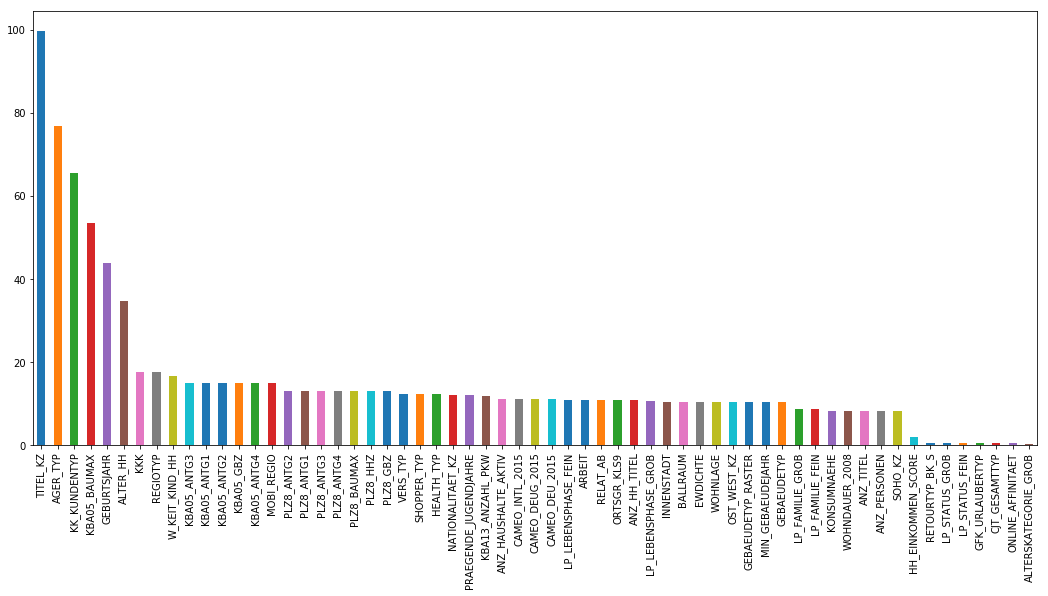

In [14]:
# Investigate patterns in the amount of missing data in each column.
azdias_nan.percent.plot.bar(figsize=(18, 8));

In [15]:
# Drop the outlier columns
columns_to_drop = azdias_nan[azdias_nan.percent > 30.].index.tolist()
#columns_to_drop
azdias.drop(columns_to_drop, axis=1, inplace=True)
#azdias_copy.head(20).T

In [16]:
#Drop the corresponding columns from feat_info
feat_info = feat_info[~feat_info.attribute.isin(columns_to_drop)]
#feat_info

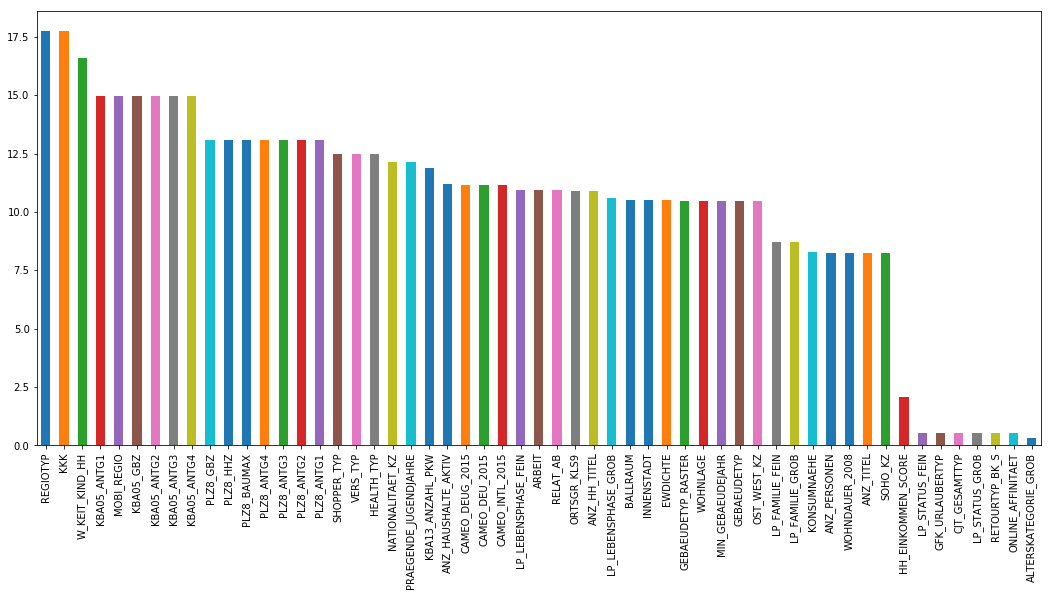

In [17]:
azdias_nan = extract_columns_with_nan(azdias)
azdias_nan.percent.plot.bar(figsize=(18, 8));

In [18]:
azdias_nan.head(5)

,sum,percent
REGIOTYP,158064,17.74
KKK,158064,17.74
W_KEIT_KIND_HH,147988,16.61
KBA05_ANTG1,133324,14.96
MOBI_REGIO,133324,14.96


In [19]:
feat_info.set_index('attribute', inplace=True, drop=False)
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
attribute,,,,
ALTERSKATEGORIE_GROB,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
ANREDE_KZ,ANREDE_KZ,person,categorical,"[-1, 0]"
CJT_GESAMTTYP,CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,FINANZ_MINIMALIST,person,ordinal,[-1]
FINANZ_SPARER,FINANZ_SPARER,person,ordinal,[-1]


In [20]:
feat_info = feat_info.join(azdias_nan)

#Percentage
feat_info.sort_values(by='percent', ascending=False, inplace=True)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [21]:
# Perform an assessment of how much missing data there is in each column of the dataset.

def extract_columns_with_nan(df):

    # Extract columns with NaNs
    columns_with_nans = df.isnull().sum()[df.isnull().sum() > 0]

    # Calculate percentage of NaN for each column
    dic_nan = {'sum': columns_with_nans.values, 'percent': np.round(columns_with_nans.values * 100 / df.shape[0], 2)}

    # Build a dataframe including only columns with NaNs
    df_nan = pd.DataFrame(data=dic_nan, index=columns_with_nans.index)

    # Sort by percentage
    df_nan.sort_values(by='percent', ascending=False, inplace=True)

    return df_nan


In [22]:
azdias_nan = extract_columns_with_nan(azdias)
azdias_nan

,sum,percent
REGIOTYP,158064,17.74
KKK,158064,17.74
W_KEIT_KIND_HH,147988,16.61
KBA05_ANTG1,133324,14.96
MOBI_REGIO,133324,14.96
KBA05_GBZ,133324,14.96
KBA05_ANTG2,133324,14.96
KBA05_ANTG3,133324,14.96
KBA05_ANTG4,133324,14.96
PLZ8_GBZ,116515,13.07


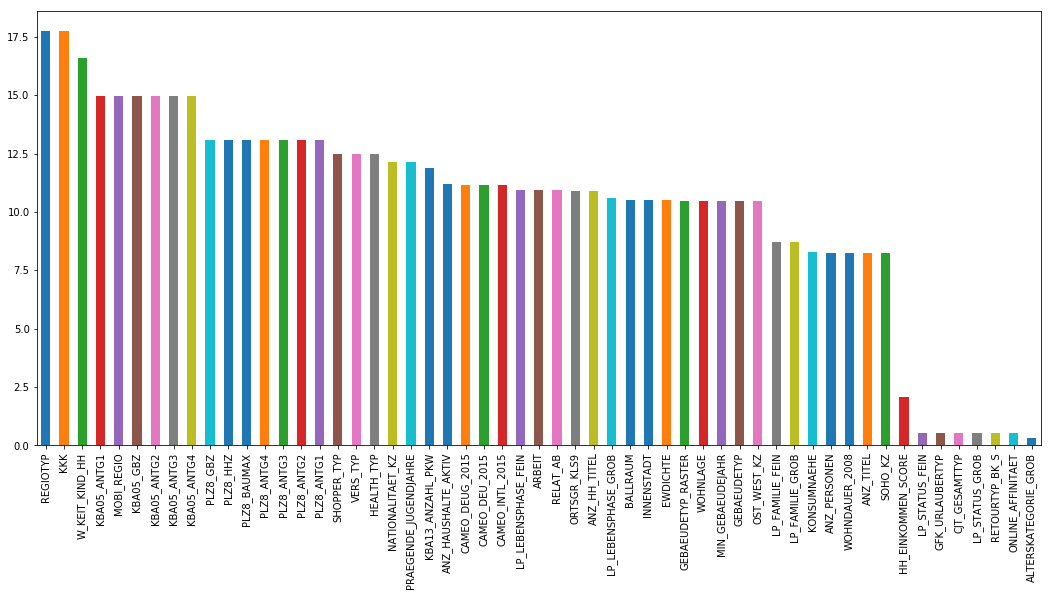

In [23]:
#Displaying patterns in the amount of missing data in each column.
azdias_nan.percent.plot.bar(figsize=(18, 8));

In [24]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

columns_to_drop = azdias_nan[azdias_nan.percent > 30.].index.tolist()

azdias.drop(columns_to_drop, axis=1, inplace=True)

In [25]:
# Drop the corresponding columns from feat_info
feat_info = feat_info[~feat_info.attribute.isin(columns_to_drop)]

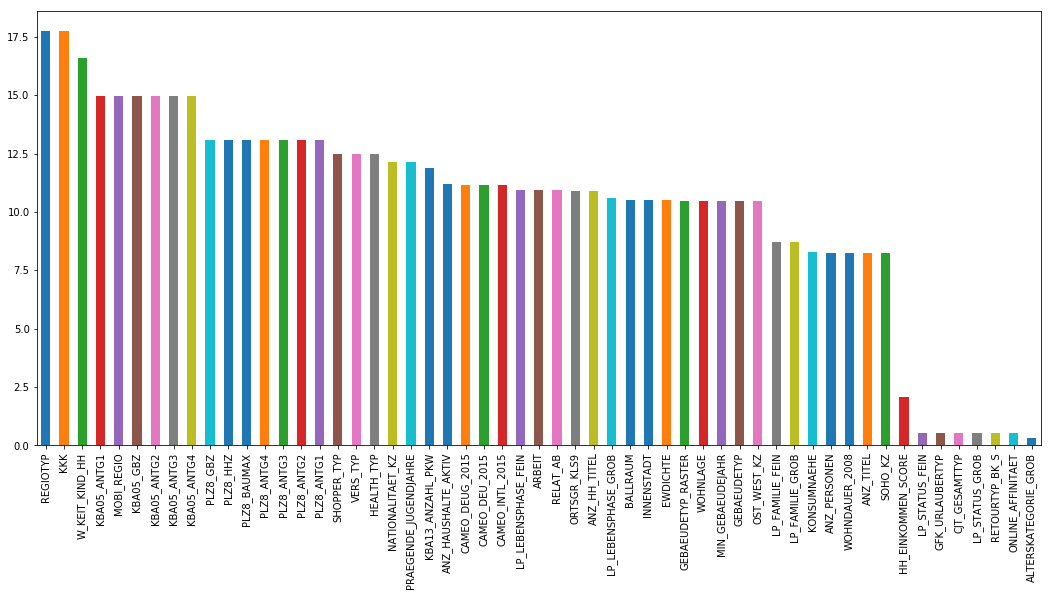

In [26]:
# Investigate patterns in the amount of missing data in remaining columns
azdias_nan = extract_columns_with_nan(azdias)
azdias_nan.percent.plot.bar(figsize=(18, 8));

In [27]:
azdias_nan.head(5)

,sum,percent
REGIOTYP,158064,17.74
KKK,158064,17.74
W_KEIT_KIND_HH,147988,16.61
KBA05_ANTG1,133324,14.96
MOBI_REGIO,133324,14.96


In [28]:
feat_info.set_index('attribute', inplace=True, drop=False)
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown,sum,percent
attribute,,,,,,
REGIOTYP,REGIOTYP,region_rr1,ordinal,"[-1, 0]",158064.0,17.74
KKK,KKK,region_rr1,ordinal,"[-1, 0]",158064.0,17.74
W_KEIT_KIND_HH,W_KEIT_KIND_HH,household,ordinal,"[-1, 0]",147988.0,16.61
KBA05_ANTG1,KBA05_ANTG1,microcell_rr3,ordinal,[-1],133324.0,14.96
MOBI_REGIO,MOBI_REGIO,region_rr1,ordinal,[],133324.0,14.96


#### Discussion 1.1.2: Assess Missing Data in Each Column

Columns are made of data of various types (categorical, ordinal, numeric, mixed). 

The column with the highest missing value is TITEL_KZ with 99.79 missing value.

ALTERSKATEGORIE_GROB has the least missing values with 0.32%. There are 61 columns with missing value.

The outlier removal process showed that columns with more than 20% missing data are outliers and are dropped from the table.

In [29]:
df_num = azdias.select_dtypes(include = ['float64', 'int64'])
df_num.shape

(891221, 75)

In [30]:
n = len(azdias)
for column in df_num:
    n_unique = len(azdias[column].unique())
    print('feature: {}'.format(column))
    print('unique values: {}'.format(n_unique))
    print('unique values ratio: {}'.format(n_unique / n))
    print('missinge value ratio: {}'.format(azdias[column].isnull().sum() / n))

feature: ALTERSKATEGORIE_GROB
unique values: 5
unique values ratio: 5.610280727227029e-06
missinge value ratio: 0.0032326437550282143
feature: ANREDE_KZ
unique values: 2
unique values ratio: 2.2441122908908116e-06
missinge value ratio: 0.0
feature: CJT_GESAMTTYP
unique values: 7
unique values ratio: 7.854393018117841e-06
missinge value ratio: 0.005446460529992
feature: FINANZ_MINIMALIST
unique values: 5
unique values ratio: 5.610280727227029e-06
missinge value ratio: 0.0
feature: FINANZ_SPARER
unique values: 5
unique values ratio: 5.610280727227029e-06
missinge value ratio: 0.0
feature: FINANZ_VORSORGER
unique values: 5
unique values ratio: 5.610280727227029e-06
missinge value ratio: 0.0
feature: FINANZ_ANLEGER
unique values: 5
unique values ratio: 5.610280727227029e-06
missinge value ratio: 0.0
feature: FINANZ_UNAUFFAELLIGER
unique values: 5
unique values ratio: 5.610280727227029e-06
missinge value ratio: 0.0
feature: FINANZ_HAUSBAUER
unique values: 5
unique values ratio: 5.6102807272

In [31]:
# Identify correlations between numeric features
def correlated_columns_to_drop(df, min_corr_level=0.95):

    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than min_corr_level
    to_drop = [column for column in upper.columns if any(upper[column] > min_corr_level)]

    return to_drop

In [32]:
columns_to_drop = correlated_columns_to_drop(df_num, 0.95)

In [33]:
columns_to_drop

['LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB']

In [34]:
azdias.drop(columns_to_drop, axis=1, inplace=True)
feat_info = feat_info[~feat_info.attribute.isin(columns_to_drop)]

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [35]:
# How much data is missing in each row of the dataset?
missing_data_by_row = azdias.isnull().sum(axis=1)
missing_data_by_row.describe()

count    891221.000000
mean          5.363758
std          12.750325
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          45.000000
dtype: float64

In [36]:
missing_data_by_row[missing_data_by_row == 45]

643174    45
732775    45
dtype: int64

In [37]:
count_all_rows = missing_data_by_row.count()
count_rows_no_missing_data = missing_data_by_row[missing_data_by_row == 0].count()
count_rows_with_missing_data = missing_data_by_row[missing_data_by_row != 0].count()
percent_rows_with_missing_data = count_rows_with_missing_data * 100 / count_all_rows
percent_rows_no_missing_data = 100 - percent_rows_with_missing_data

print('{}\t -> Total rows = 100%.'.format(count_all_rows))
print('{}\t -> Rows with missing data = {:0.2f}%.'.format(count_rows_with_missing_data, percent_rows_with_missing_data))
print('{}\t -> Rows with no missing data = {:0.2f}%.'.format(count_rows_no_missing_data, percent_rows_no_missing_data))

891221	 -> Total rows = 100%.
268012	 -> Rows with missing data = 30.07%.
623209	 -> Rows with no missing data = 69.93%.


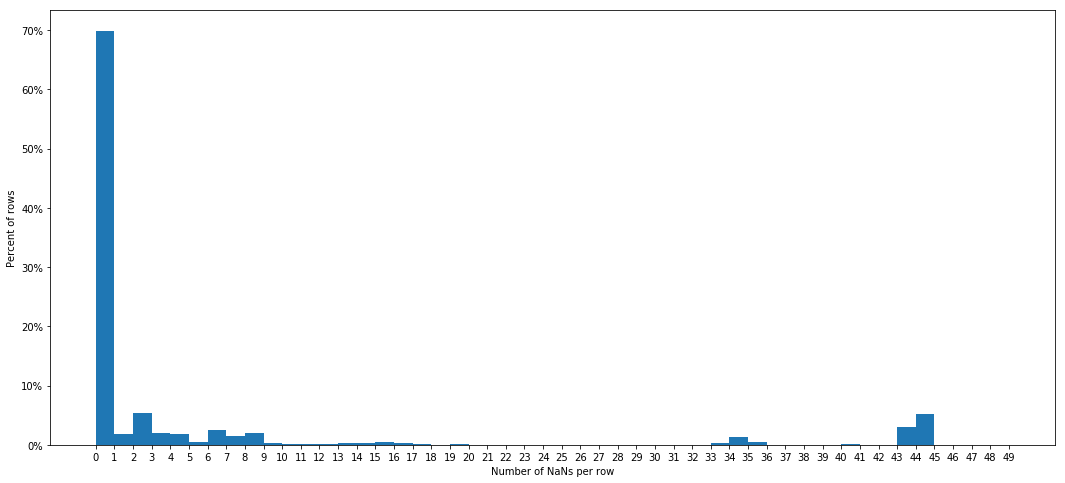

In [38]:
plt.figure(figsize=(18, 8))
plt.xticks(np.arange(0, 50, 1))
plt.xlabel('Number of NaNs per row')
plt.ylabel('Percent of rows')
# Percent of observations in the Y axis
plt.hist(missing_data_by_row, weights=np.ones(len(missing_data_by_row)) / len(missing_data_by_row), bins=np.arange(0, 50, 1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show();

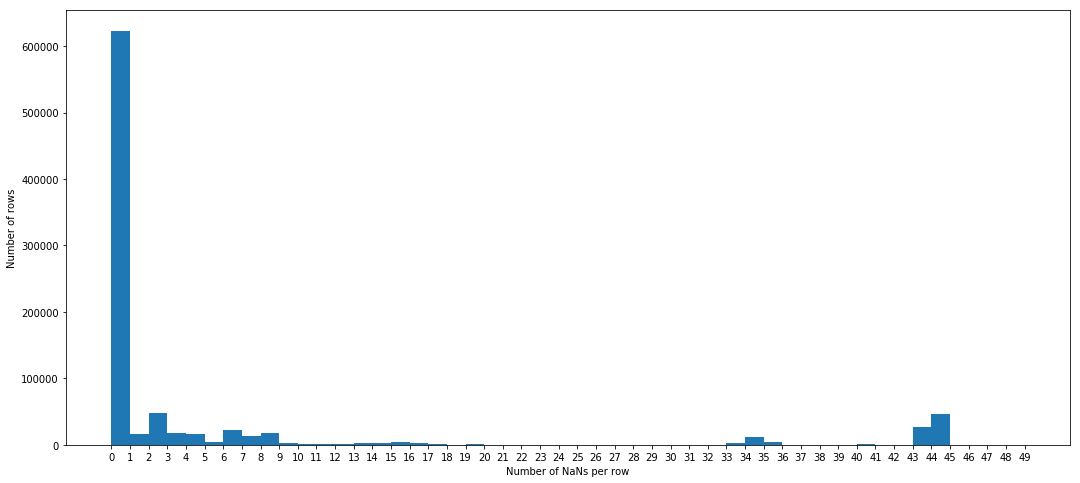

In [39]:
plt.figure(figsize=(18, 8))
plt.xticks(np.arange(0, 50, 1))
plt.xlabel('Number of NaNs per row')
plt.ylabel('Number of rows')
# Number of observations in the Y axis
plt.hist(missing_data_by_row, bins=np.arange(0, 50, 1));

In [40]:
# Write code to divide the data into two subsets based on the number of missing values in each row.
azdias = azdias.assign(NAN_NUM=pd.Series(missing_data_by_row.values))
azdias.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NAN_NUM
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0
7,1.0,1,3.0,3,3,4,1,3,2,5,...,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0,0
8,3.0,1,3.0,4,4,2,4,2,2,6,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0,0
9,3.0,2,4.0,2,4,2,3,5,4,1,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,0


In [41]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
np.random.seed(23456)
sample_columns = np.random.choice(azdias.columns, 5).tolist()
print(sample_columns)

['WOHNDAUER_2008', 'ZABEOTYP', 'PLZ8_ANTG2', 'SEMIO_FAM', 'SEMIO_KRIT']


In [42]:
#selecting 30 as the threshold value
split_value = 15
high_nan_rows = azdias[azdias.NAN_NUM >= split_value].copy()
low_nan_rows = azdias[azdias.NAN_NUM < split_value].copy()

In [43]:
#selecting 30 as the threshold value
split_value = 15
high_nan_rows = azdias[azdias.NAN_NUM >= split_value].copy()
low_nan_rows = azdias[azdias.NAN_NUM < split_value].copy()

In [44]:
sample_low_nan_rows = low_nan_rows.sample(5)
sample_low_nan_rows

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NAN_NUM
722883,4.0,1,6.0,5,1,5,1,2,3,5,...,4.0,2.0,1.0,5.0,3.0,2.0,4.0,8.0,3.0,0
411586,3.0,2,5.0,2,4,4,4,2,3,6,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,7.0,5.0,0
222582,1.0,2,3.0,1,5,1,4,3,4,1,...,4.0,3.0,1.0,3.0,4.0,3.0,4.0,8.0,5.0,0
574881,3.0,1,2.0,5,2,4,2,2,1,6,...,3.0,0.0,0.0,1.0,3.0,4.0,2.0,4.0,1.0,0
197700,3.0,2,3.0,2,5,2,4,3,2,6,...,2.0,1.0,0.0,1.0,3.0,4.0,2.0,4.0,1.0,0


In [45]:
def compare_dist_for_a_column(df, column_name, split_value):
    fig = plt.figure(figsize=(18, 8))
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Incomplete')
    sns.countplot(df.loc[df.NAN_NUM >= split_value, column_name])

    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Complete')
    sns.countplot(df.loc[~df.NAN_NUM < split_value, column_name])

    fig.suptitle(column_name)
    plt.show();
    
    print(stats.ks_2samp(df.loc[df.NAN_NUM >= split_value, column_name], df.loc[~df.NAN_NUM < split_value, column_name]))

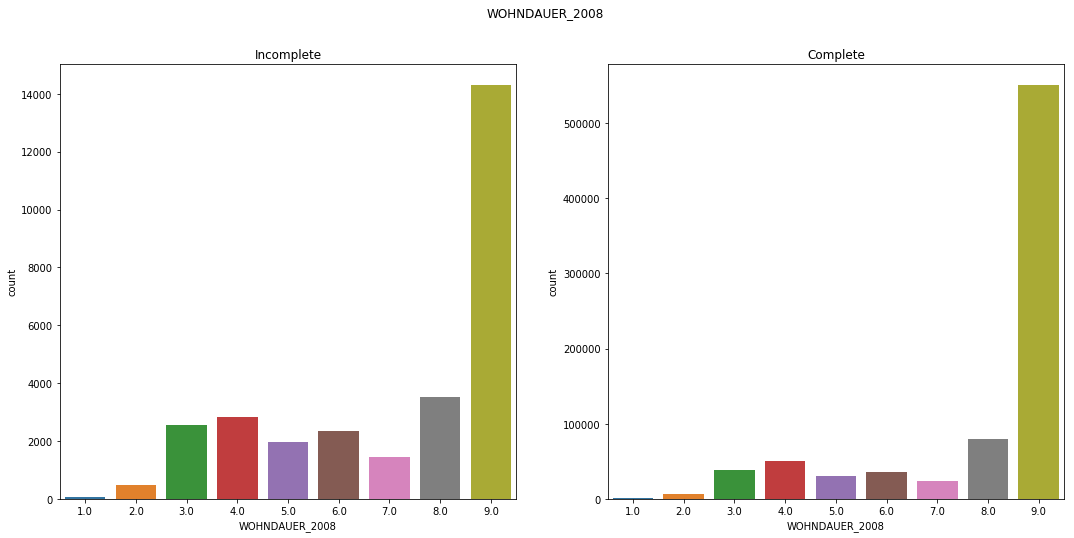

Ks_2sampResult(statistic=0.63111251963775272, pvalue=0.0)


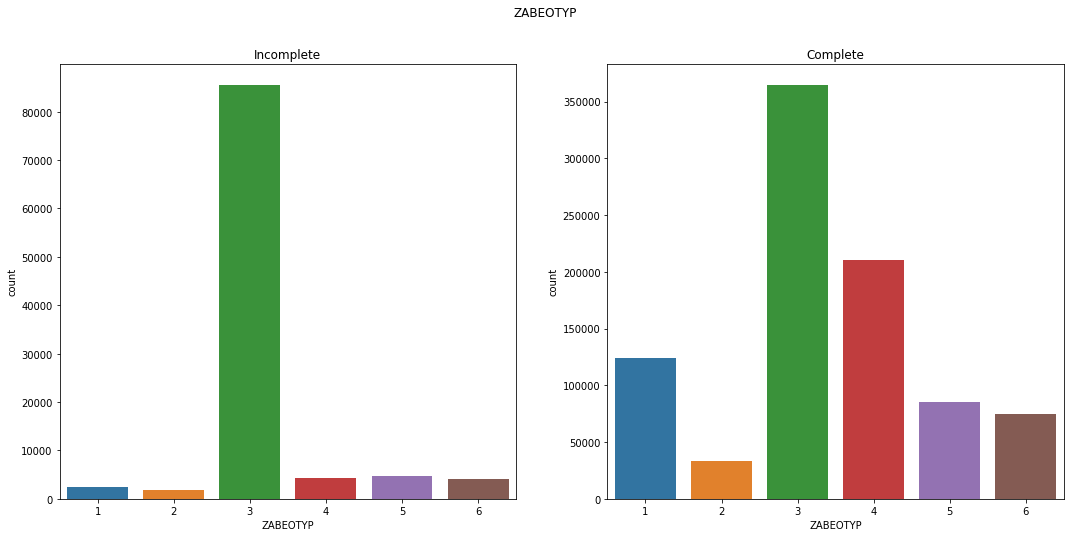

Ks_2sampResult(statistic=0.28700531586626721, pvalue=0.0)


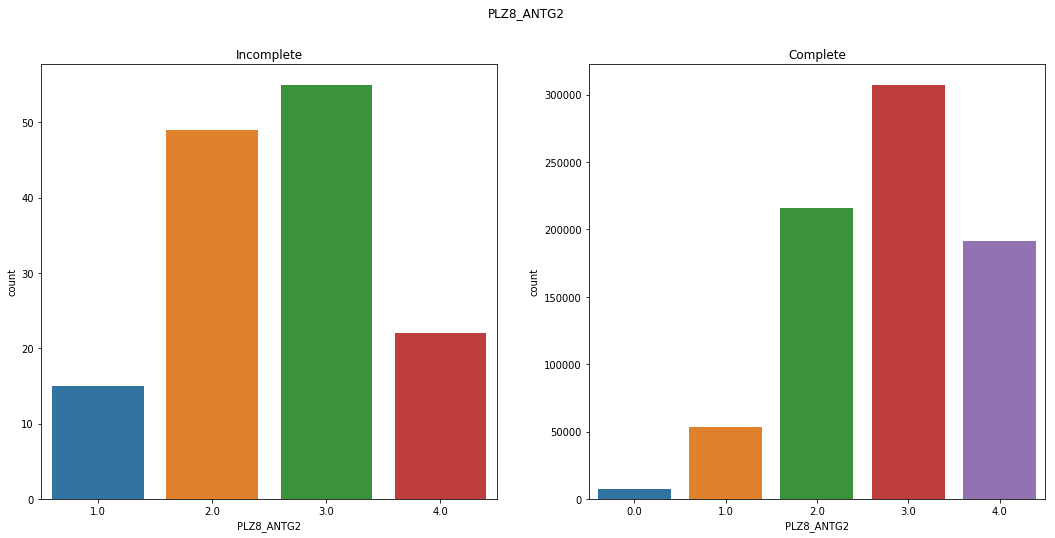

Ks_2sampResult(statistic=0.86789469617459358, pvalue=0.0)


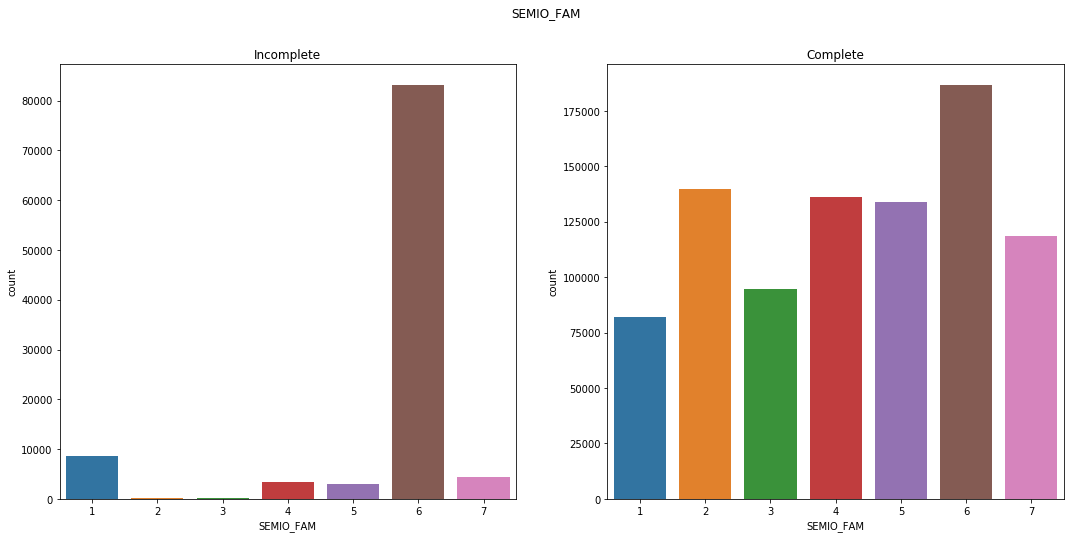

Ks_2sampResult(statistic=0.50851626730309984, pvalue=0.0)


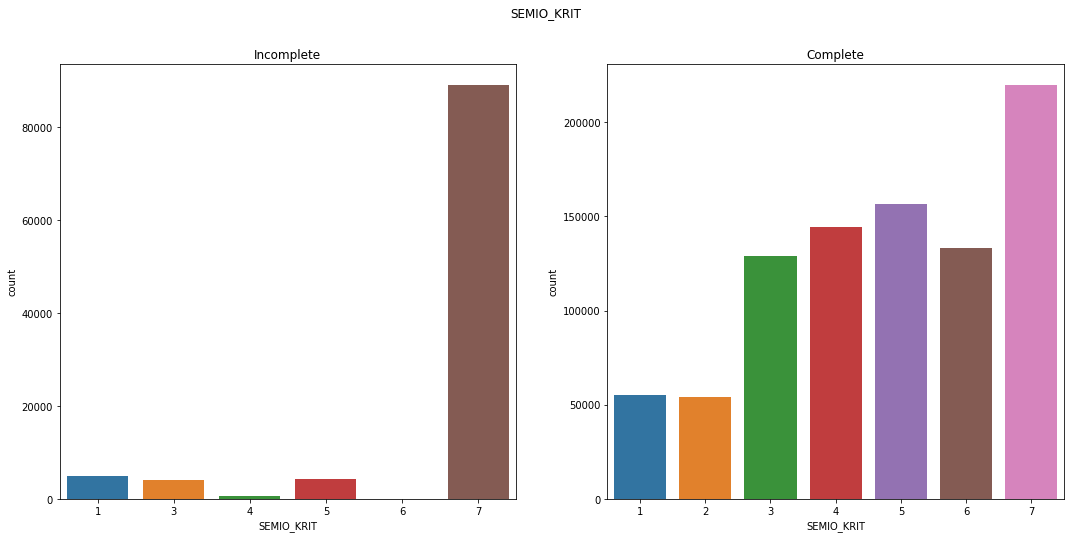

Ks_2sampResult(statistic=0.61830961385439975, pvalue=0.0)


In [46]:
for col in sample_columns:
    compare_dist_for_a_column(azdias, col, split_value)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Missing data represents about 30% of all data and as can be seen from the graphs, there are no considerable differences between the two categories

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [47]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    15
numeric         6
mixed           5
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [48]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?



In [49]:
# Re-encode categorical variable(s) to be kept in the analysis.
categorical_features = feat_info[feat_info.type == 'categorical'].attribute
#categorical_features = feat_info.query('type == \'categorical\'').attribute
print(categorical_features)

attribute
SHOPPER_TYP              SHOPPER_TYP
VERS_TYP                    VERS_TYP
NATIONALITAET_KZ    NATIONALITAET_KZ
CAMEO_DEUG_2015      CAMEO_DEUG_2015
CAMEO_DEU_2015        CAMEO_DEU_2015
GEBAEUDETYP              GEBAEUDETYP
OST_WEST_KZ              OST_WEST_KZ
SOHO_KZ                      SOHO_KZ
LP_STATUS_FEIN        LP_STATUS_FEIN
GFK_URLAUBERTYP      GFK_URLAUBERTYP
CJT_GESAMTTYP          CJT_GESAMTTYP
ANREDE_KZ                  ANREDE_KZ
FINANZTYP                  FINANZTYP
GREEN_AVANTGARDE    GREEN_AVANTGARDE
ZABEOTYP                    ZABEOTYP
Name: attribute, dtype: object


In [50]:
categorical_binary = []
categorical_multi = []
for feature in categorical_features:
    if azdias[feature].nunique() > 2:
        categorical_multi.append(feature)
    else:
        categorical_binary.append(feature)

In [51]:
for col in categorical_binary:
    print(azdias[col].value_counts())

2.0    398722
1.0    381303
Name: VERS_TYP, dtype: int64
W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64
0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64
2    465305
1    425916
Name: ANREDE_KZ, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64


In [52]:
azdias['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
azdias['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)

In [53]:
for col in categorical_binary:
    print(azdias[col].value_counts())

1.0    398722
0.0    381303
Name: VERS_TYP, dtype: int64
1.0    629528
0.0    168545
Name: OST_WEST_KZ, dtype: int64
0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64
1    465305
0    425916
Name: ANREDE_KZ, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64


In [54]:
for col in categorical_multi:
    print(azdias[col].value_counts())

1.0    254761
2.0    207463
3.0    190219
0.0    127582
Name: SHOPPER_TYP, dtype: int64
1.0    684085
2.0     65418
3.0     33403
Name: NATIONALITAET_KZ, dtype: int64
8    134441
9    108177
6    105874
4    103912
3     86779
2     83231
7     77933
5     55310
1     36212
Name: CAMEO_DEUG_2015, dtype: int64
6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
Name: CAMEO_DEU_2015, dtype: int64
1.0    460465
3.0    178668
8.0    152476
2.0      4935
4.0       900
6.0       628
5.0         1
Name: GEBAEUDETYP, dtype: in

In [55]:
azdias = pd.get_dummies(azdias, columns=categorical_multi)

#### Discussion 1.2.1: Re-Encode Categorical Features

I used Binary (two-level) categoricals that take numeric values (0 and 1).

For multi-level categorical variables, I used one-hot encoding.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [56]:
# Select mixed features names
mixed_features = feat_info[feat_info.type == 'mixed'].attribute
print(mixed_features)

attribute
PLZ8_BAUMAX                        PLZ8_BAUMAX
PRAEGENDE_JUGENDJAHRE    PRAEGENDE_JUGENDJAHRE
CAMEO_INTL_2015                CAMEO_INTL_2015
LP_LEBENSPHASE_FEIN        LP_LEBENSPHASE_FEIN
WOHNLAGE                              WOHNLAGE
Name: attribute, dtype: object


In [57]:
azdias[mixed_features].sample(15).T

,130332,346697,92658,33006,43759,1139,546862,515270,407393,590009,651434,89796,100063,762788,162545
PLZ8_BAUMAX,4,1,1,2,1,1,1,3,NaN,1,3,1,5,1,1
PRAEGENDE_JUGENDJAHRE,14,10,5,14,3,NaN,5,14,NaN,11,14,10,8,NaN,3
CAMEO_INTL_2015,51,14,22,51,41,43,25,51,NaN,22,43,22,51,45,14
LP_LEBENSPHASE_FEIN,14,37,37,1,31,NaN,9,1,NaN,39,1,10,37,NaN,19
WOHNLAGE,2,7,5,4,4,7,4,4,NaN,3,3,3,3,2,7


In [58]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Generation 
generations = {0: [1, 2], # 40s
               1: [3, 4], # 50s
               2: [5, 6, 7], # 60s
               3: [8, 9], # 70s
               4: [10, 11, 12, 13], # 80s
               5:[14, 15]} # 90s

def classify_generation(value):
    try:
        for key, values in generations.items():
            if value in values:
                return key
    # In case value is NaN
    except ValueError:
        return np.nan
    
# Movement 
mainstream = [1, 3, 5, 8, 10, 12, 14]

def classify_movement(value):
    try:
        if value in mainstream:
            return 1
        else:
            return 0
    # In case value is NaN
    except ValueError:
        return np.nan


In [59]:
# Engineer generation column
azdias['PRAEGENDE_JUGENDJAHRE_GEN'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(classify_generation)
#azdias.loc[:,'PRAEGENDE_JUGENDJAHRE_GEN'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(classify_generation)

# Engineer movement column
azdias['PRAEGENDE_JUGENDJAHRE_MOV'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(classify_movement)
#azdias_new.loc[:,'PRAEGENDE_JUGENDJAHRE_MOV'] = azdias_new['PRAEGENDE_JUGENDJAHRE'].apply(classify_movement)

In [60]:
azdias.sample(15).T

,471663,701904,781738,403693,870437,428887,548260,124308,829627,211071,269272,12119,53410,793922,859925
ALTERSKATEGORIE_GROB,1,1,4,3,4,3,3,2,4,1,3,4,2,3,3
ANREDE_KZ,1,1,1,1,1,0,1,1,1,0,1,1,1,1,0
FINANZ_MINIMALIST,2,1,2,1,3,4,2,1,4,1,3,3,3,2,5
FINANZ_SPARER,4,5,1,5,1,2,5,4,1,5,2,2,4,4,3
FINANZ_VORSORGER,2,2,5,3,5,4,1,1,5,2,3,5,3,1,4
FINANZ_ANLEGER,3,5,1,5,1,1,1,3,1,5,4,1,5,5,2
FINANZ_UNAUFFAELLIGER,5,3,1,3,1,3,5,5,2,3,3,2,5,3,3
FINANZ_HAUSBAUER,3,5,5,5,5,3,3,4,4,5,2,5,3,5,1
GREEN_AVANTGARDE,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0
HEALTH_TYP,3,3,2,NaN,1,3,NaN,2,1,3,2,1,NaN,3,3


In [61]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# first digit -> wealth
# second digit -> life stage

# Wealth 
def classify_wealth(value):
    # In case value is NaN
    if pd.isnull(value):
        return np.nan
    else:
        # Return first digit
        return int(str(value)[0])

# Life stage
def classify_lifestage(value):
    # In case value is NaN
    if pd.isnull(value):
        return np.nan
    else:
        # Return second digit
        return int(str(value)[1])



In [62]:
# Engineer wealth column
azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015'].apply(classify_wealth)

# Engineer life stage column
azdias['CAMEO_INTL_2015_LIFESTAGE'] = azdias['CAMEO_INTL_2015'].apply(classify_lifestage)

In [63]:
azdias.sample(15).T

,521578,833493,601056,605964,265532,408870,336147,772989,482433,311961,441118,286042,483751,733589,296432
ALTERSKATEGORIE_GROB,3,4,3,3,3,3,2,2,3,4,1,1,3,3,3
ANREDE_KZ,1,0,1,0,1,0,1,1,1,0,0,0,1,0,1
FINANZ_MINIMALIST,1,5,4,3,1,4,1,4,3,3,4,3,5,5,2
FINANZ_SPARER,5,1,2,3,4,1,5,4,3,1,1,4,2,2,4
FINANZ_VORSORGER,1,4,3,4,2,5,2,2,4,5,5,3,3,3,3
FINANZ_ANLEGER,2,1,4,3,5,2,4,4,2,1,1,5,3,5,5
FINANZ_UNAUFFAELLIGER,5,1,2,2,5,1,5,5,2,1,2,5,3,5,5
FINANZ_HAUSBAUER,4,3,1,2,3,5,4,1,2,4,5,3,1,1,3
GREEN_AVANTGARDE,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0
HEALTH_TYP,2,2,3,3,NaN,3,2,2,1,2,NaN,NaN,2,1,NaN


In [64]:
azdias = azdias.drop(['PRAEGENDE_JUGENDJAHRE',
                      'CAMEO_INTL_2015',
                      'PLZ8_BAUMAX',
                      'LP_LEBENSPHASE_FEIN',
                      'WOHNLAGE',
                      'REGIOTYP',
                      'KKK'], axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

I identified 6 of the mixed type features. 

To further this process I have engineered 4 new features; 2 decode PRAEGENDE_JUGENDJAHRE and 2 to decode CAMEO_INTL_2015.  

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [65]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

columns_to_drop = correlated_columns_to_drop(azdias, 0.95)
columns_to_drop.append('GEBAEUDETYP_5.0')

In [66]:
# Remove highly correlated numerical features
azdias.drop(columns_to_drop, axis=1, inplace=True)
feat_info = feat_info[~feat_info.attribute.isin(columns_to_drop)]

In [67]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Remove NAN_NUM column
if 'NAN_NUM' in azdias.columns:
    azdias = azdias.drop(['NAN_NUM'], axis=1)

# Check
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 168 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_LIFESTAGE
dtypes: float64(39), int64(23), uint8(106)
memory usage: 511.7 MB


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [68]:
def clean_data(azdias, feat_info, split_value):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame, feature info DataFrame, and split_value
    OUTPUT: Trimmed and cleaned demographics DataFrame and feature info DataFrame
    """
    
    # Remove brackets and split strings into lists
    # in feat_info.missing_or_unknown
    if type(feat_info.missing_or_unknown[0]) == str:
        feat_info.missing_or_unknown = feat_info.missing_or_unknown.str.strip('[').str.strip(']').str.split(',')
    
    # Replace with NaNs all values in all columns of azdias as per mapping in feat_info
    azdias = replace_missing_values_with_nan(azdias, feat_info, 'attribute', 'missing_or_unknown', non_numerical_indicators=['X', 'XX'])

    azdias_nan = extract_columns_with_nan(azdias)

    # Drop the outlier columns
    columns_to_drop = azdias_nan[azdias_nan.percent > 30.].index.tolist()
    azdias.drop(columns_to_drop, axis=1, inplace=True)

    # Drop the corresponding columns from feat_info
    feat_info = feat_info[~feat_info.attribute.isin(columns_to_drop)]

    # In order to merge to dataframes by index we need to have indexes
    # as attributes in both dataframes
    feat_info.set_index('attribute', inplace=True, drop=False)

    # Add NaN information columns to feat_info
    # by index / rows, for better columns understanding
    #feat_info = feat_info.join(azdias_nan)
    
    # Examin numerical features
    df_num = azdias.select_dtypes(include = ['float64', 'int64'])
    
    # Remove highly correlated numerical features
    columns_to_drop = correlated_columns_to_drop(df_num, 0.95)
    azdias.drop(columns_to_drop, axis=1, inplace=True)
    feat_info = feat_info[~feat_info.attribute.isin(columns_to_drop)]
    
    missing_data_by_row = azdias.isnull().sum(axis=1)
    
    # Add information about number of NaN for each row to the master dataset
    azdias = azdias.assign(NAN_NUM=pd.Series(missing_data_by_row.values))
    
    high_nan_rows = azdias[azdias.NAN_NUM >= split_value].copy()
    low_nan_rows = azdias[azdias.NAN_NUM < split_value].copy()

    # Remove all rows with missing values above split_value
    azdias = azdias[azdias.NAN_NUM < split_value]
    
    # Select categorical features names
    categorical_features = feat_info[feat_info.type == 'categorical'].attribute

    # Split categorical variables into binary or multi buckets
    categorical_binary = []
    categorical_multi = []
    for feature in categorical_features:
        if azdias[feature].nunique() > 2:
            categorical_multi.append(feature)
        else:
            categorical_binary.append(feature)

    # Standardize binary columns into 0 or 1
    azdias['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
    azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
    azdias['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)

    # Do one-hot-encoding and remove reference columns
    azdias = pd.get_dummies(azdias, columns=categorical_multi)

    # Select mixed features names
    mixed_features = feat_info[feat_info.type == 'mixed'].attribute

    # Engineer features
    azdias['PRAEGENDE_JUGENDJAHRE_GEN'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(classify_generation)
    azdias['PRAEGENDE_JUGENDJAHRE_MOV'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(classify_movement)
    azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015'].apply(classify_wealth)
    azdias['CAMEO_INTL_2015_LIFESTAGE'] = azdias['CAMEO_INTL_2015'].apply(classify_lifestage)
    
    # Remove unneeded and the rest of mixed columns (as per instruction above)
    azdias = azdias.drop(['PRAEGENDE_JUGENDJAHRE',
                          'CAMEO_INTL_2015',
                          'PLZ8_BAUMAX',
                          'LP_LEBENSPHASE_FEIN',
                          'WOHNLAGE'], axis=1)
    
    if 'REGIOTYP' in azdias.columns:
        azdias = azdias.drop(['REGIOTYP'], axis=1)
        
    if 'KKK' in azdias.columns:
        azdias = azdias.drop(['KKK'], axis=1)
        
    if 'KBA05_BAUMAX' in azdias.columns:
        azdias = azdias.drop(['KBA05_BAUMAX'], axis=1)
        
    if 'TITEL_KZ' in azdias.columns:
        azdias = azdias.drop(['TITEL_KZ'], axis=1)
        
    if 'AGER_TYP' in azdias.columns:
        azdias = azdias.drop(['AGER_TYP'], axis=1)
        
    if 'GEBURTSJAHR' in azdias.columns:
        azdias = azdias.drop(['GEBURTSJAHR'], axis=1)
        
    if 'ALTER_HH' in azdias.columns:
        azdias = azdias.drop(['ALTER_HH'], axis=1)
        
    if 'GEBAEUDETYP_5.0' in azdias.columns:
        azdias = azdias.drop(['GEBAEUDETYP_5.0'], axis=1)

    # Remove highly correlated numerical features
    columns_to_drop = correlated_columns_to_drop(azdias, 0.95)
    azdias.drop(columns_to_drop, axis=1, inplace=True)
    feat_info = feat_info[~feat_info.attribute.isin(columns_to_drop)]

    # Remove NAN_NUM column
    azdias = azdias.drop(['NAN_NUM'], axis=1)
    
    return azdias, feat_info, high_nan_rows, low_nan_rows

In [69]:
# Load in the general demographics data.
azdias_clean = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info_clean = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

split_value = 1

azdias_clean, feat_info_clean, high_nan_rows_clean, low_nan_rows_clean = clean_data(azdias_clean, feat_info_clean, split_value)

In [70]:
# After test
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Columns: 164 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_LIFESTAGE
dtypes: float64(35), int64(26), uint8(103)
memory usage: 356.0 MB


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [71]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.



In [72]:
# Apply feature scaling to the general population demographics data.



In [73]:
# Number of rows with missing data comparing to number of all rows
count_all_rows = azdias_clean.shape[0]
azdias_clean_nans = azdias_clean[azdias_clean.isnull().any(axis=1)]
count_rows_with_nans = azdias_clean_nans.shape[0]
percent_nans = count_rows_with_nans * 100 / count_all_rows
print('All rows {}, complete rows {}, incomplete rows {} ({:0.2f}%)'.format(count_all_rows,
                                                                      count_all_rows - count_rows_with_nans,
                                                                      count_rows_with_nans,
                                                                      percent_nans))

All rows 623209, complete rows 623209, incomplete rows 0 (0.00%)


### Discussion 2.1: Apply Feature Scaling

Sequal to deleting rows with NaNs, the features were scaled to mean 0 and standard deviation 1

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [74]:
scaler = StandardScaler()
azdias_clean_std = scaler.fit_transform(azdias_clean)

In [75]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_clean_std)

In [76]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca, components_no=None, show_labels=False):

    vals = pca.explained_variance_ratio_
    if components_no:
        vals = vals[:components_no]
    num_components = len(vals)
    ind = np.arange(num_components)
 
    plt.figure(figsize=(18, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    if show_labels:
        for i in range(num_components):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

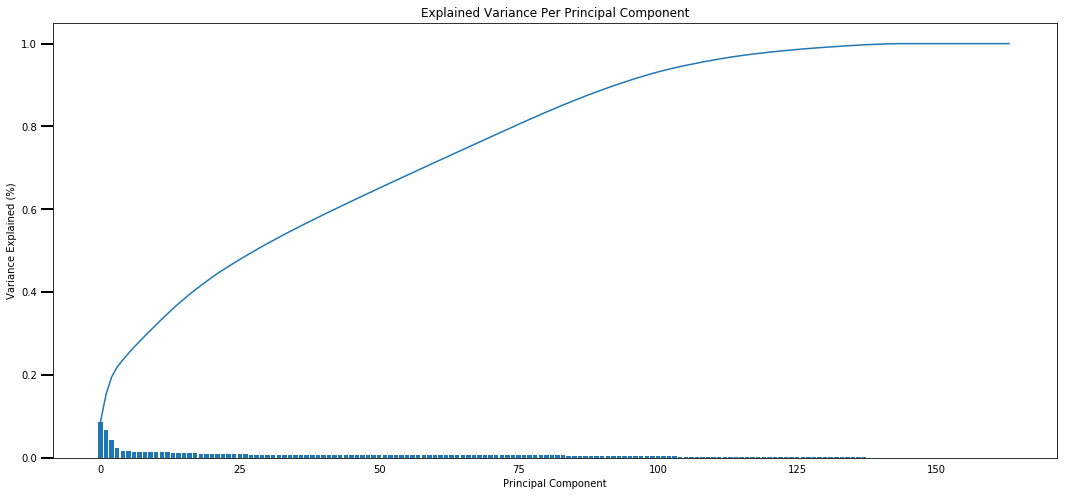

In [77]:
scree_plot(pca, show_labels=False)

In [78]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=80)
azdias_pca = pca.fit_transform(azdias_clean_std)

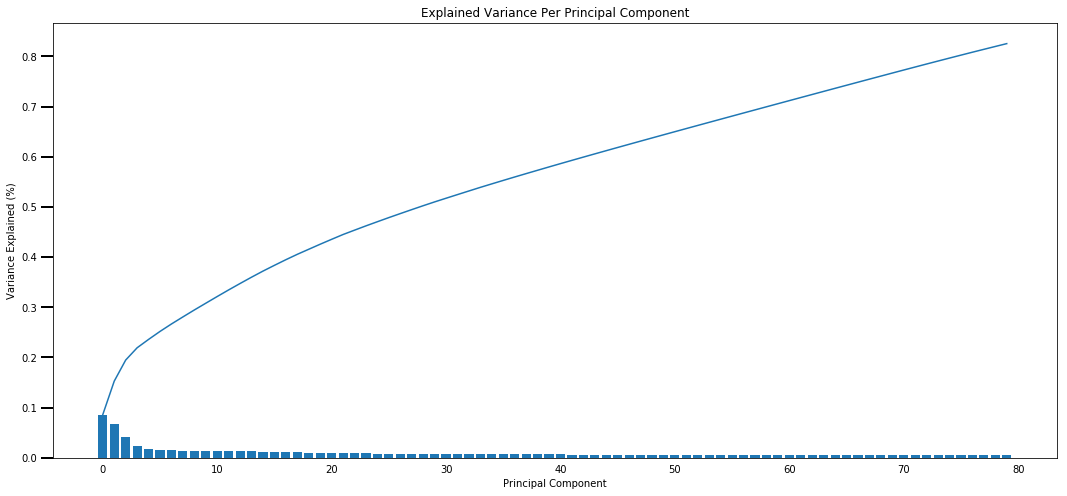

In [79]:
scree_plot(pca, show_labels=False)

### Discussion 2.2: Perform Dimensionality Reduction

I performed Principal Component Analysis. PCA shows that 80 components explain 0.8257949765405798 (83%) of variance so that was chosen.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [80]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
# for a component_no PCA component

def pca_results(df, pca, component_no, features_no, show_plot=True):
    
    # Build a dataframe with features_no features capturing most variability
    # for a given component number (component_no)
    pca_comp = pd.DataFrame(np.round(pca.components_, 4), columns=df.keys()).iloc[component_no - 1]
    pca_comp.sort_values(ascending=False, inplace=True)
    pca_comp = pd.concat([pca_comp.head(features_no), pca_comp.tail(features_no)])
    
    if show_plot:
        # Plot the result
        pca_comp.plot(kind='bar', 
                  title='Most {} weighted features for PCA component {}'.format(features_no*2, component_no),
                  figsize=(12, 6))
        plt.show()
    
    return pca_comp

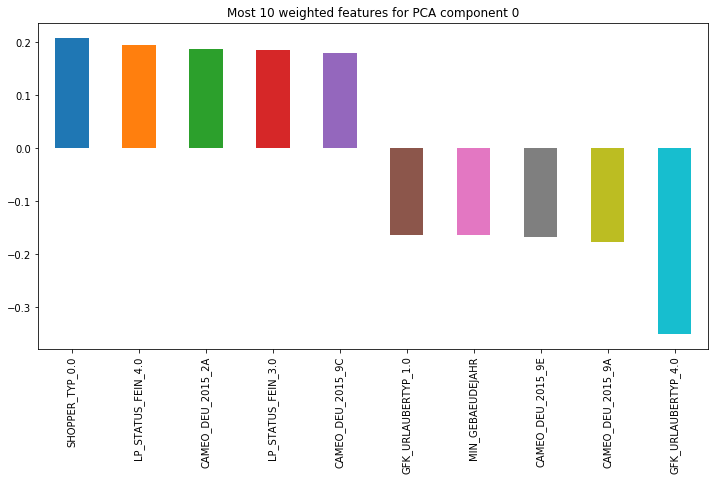

SHOPPER_TYP_0.0        0.2088
LP_STATUS_FEIN_4.0     0.1940
CAMEO_DEU_2015_2A      0.1867
LP_STATUS_FEIN_3.0     0.1855
CAMEO_DEU_2015_9C      0.1796
GFK_URLAUBERTYP_1.0   -0.1632
MIN_GEBAEUDEJAHR      -0.1634
CAMEO_DEU_2015_9E     -0.1680
CAMEO_DEU_2015_9A     -0.1774
GFK_URLAUBERTYP_4.0   -0.3502
Name: 79, dtype: float64


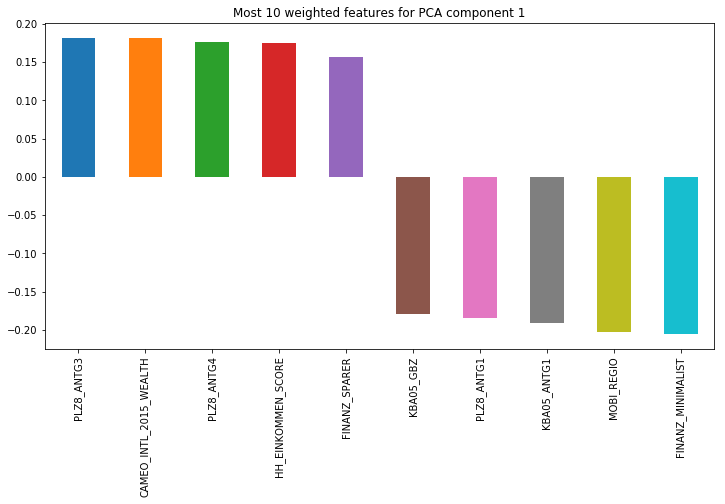

PLZ8_ANTG3                0.1816
CAMEO_INTL_2015_WEALTH    0.1809
PLZ8_ANTG4                0.1761
HH_EINKOMMEN_SCORE        0.1747
FINANZ_SPARER             0.1569
KBA05_GBZ                -0.1791
PLZ8_ANTG1               -0.1837
KBA05_ANTG1              -0.1906
MOBI_REGIO               -0.2030
FINANZ_MINIMALIST        -0.2056
Name: 0, dtype: float64


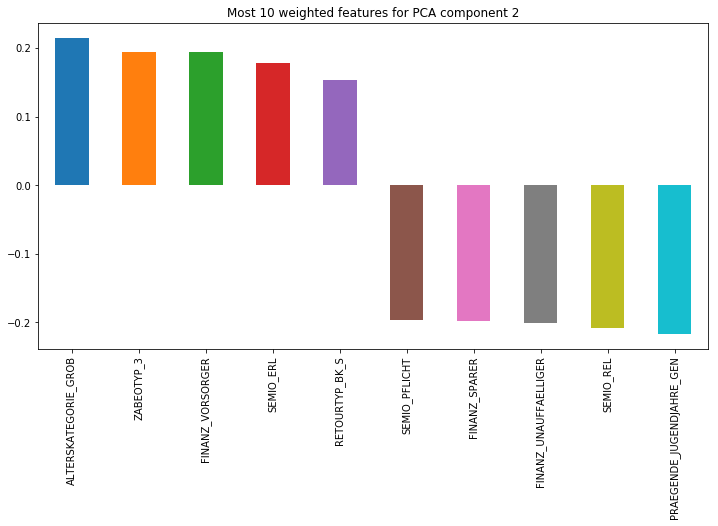

ALTERSKATEGORIE_GROB         0.2152
ZABEOTYP_3                   0.1945
FINANZ_VORSORGER             0.1940
SEMIO_ERL                    0.1779
RETOURTYP_BK_S               0.1541
SEMIO_PFLICHT               -0.1965
FINANZ_SPARER               -0.1978
FINANZ_UNAUFFAELLIGER       -0.2005
SEMIO_REL                   -0.2081
PRAEGENDE_JUGENDJAHRE_GEN   -0.2170
Name: 1, dtype: float64


In [81]:
for i in np.arange(0, 3, 1):
    res = pca_results(azdias_clean, pca, i, 5)
    print(res)

In [82]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.



In [83]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.



### Discussion 2.3: Interpret Principal Components

Principal Component Analysis 1

The first PCA is mostly influenced by social, financial and later stage of life.

Principal Component Analysis 2

The second component is influenced by houshold, surroundings, moving patterns and wealth level

Principal Component Analysis 3

The third component is influenced by age, product returns, events, savings level, openess and religiousness.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [84]:
# Create a toy dataset to reduce computation time
# Reduce the size to 25%
azdias_pca_sample = azdias_pca[np.random.choice(azdias_pca.shape[0], int(azdias_pca.shape[0]*0.25), replace=False)]
azdias_pca_sample 

array([[ 6.70637547, -0.81762037,  4.33243761, ..., -0.22413125,
         0.89466294, -1.07440406],
       [ 2.26756261, -2.88071268, -2.88753164, ..., -0.92037233,
         0.40192307,  0.25181391],
       [-2.99948569,  1.38481038,  4.55890101, ..., -0.22092686,
        -0.76407081,  1.44679942],
       ..., 
       [-3.48532686, -5.1515557 ,  2.64410256, ..., -0.81144633,
        -0.51185312, -0.14983214],
       [ 4.24959305, -0.30709155,  4.59484768, ...,  0.76905525,
        -0.79240889,  0.44630652],
       [ 5.40853045,  0.60429876,  2.83328701, ..., -0.71382924,
        -0.92529926,  0.44156464]])

In [85]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.

sse = [] # Sum of Squared Errors
k_range = np.arange(10, 31)

for k in k_range:
    kmeans = KMeans(k, random_state=1234, max_iter=30, n_jobs=-1).fit(azdias_pca_sample)
    score = np.abs(kmeans.score(azdias_pca_sample))
    sse.append(score)
    print('Clustering done for {} k, with SSE {}'.format(k, score))

Clustering done for 10 k, with SSE 16565875.309879716
Clustering done for 11 k, with SSE 16389274.690121688
Clustering done for 12 k, with SSE 16250194.950125683
Clustering done for 13 k, with SSE 16090039.86863833
Clustering done for 14 k, with SSE 15961085.995495372
Clustering done for 15 k, with SSE 15825398.924282756
Clustering done for 16 k, with SSE 15682095.358921885
Clustering done for 17 k, with SSE 15599038.546351323
Clustering done for 18 k, with SSE 15464760.076825444
Clustering done for 19 k, with SSE 15349216.53820482
Clustering done for 20 k, with SSE 15219378.894950021
Clustering done for 21 k, with SSE 15159206.546974918
Clustering done for 22 k, with SSE 14995822.612612732
Clustering done for 23 k, with SSE 14883238.021321425
Clustering done for 24 k, with SSE 14782640.589499278
Clustering done for 25 k, with SSE 14666962.056847373
Clustering done for 26 k, with SSE 14551249.564441951
Clustering done for 27 k, with SSE 14380287.08933365
Clustering done for 28 k, with 

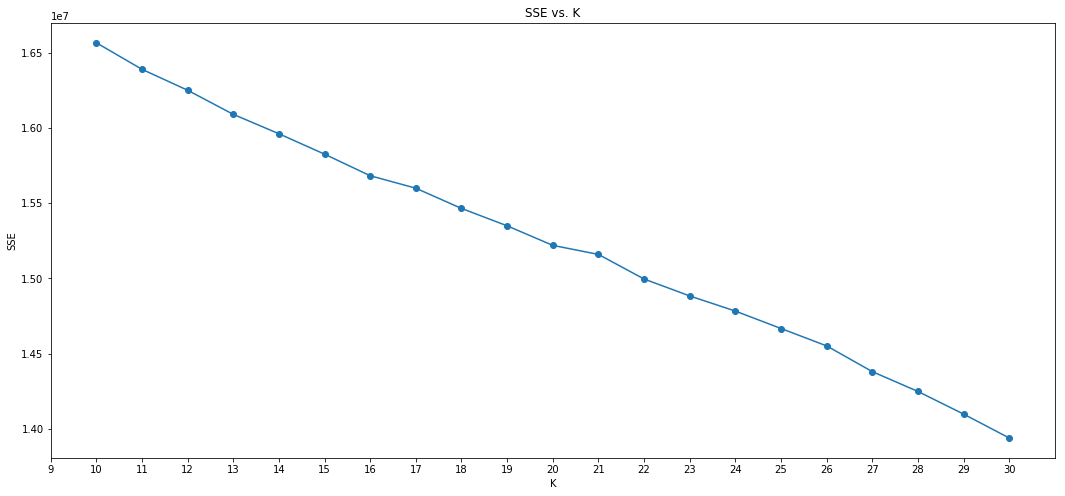

In [86]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(18, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')
plt.plot(k_range, sse, linestyle='-', marker='o');

In [87]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k = 24
kmeans = KMeans(k, random_state=1234, max_iter=30, n_jobs=-1).fit(azdias_pca)
population_clusters = kmeans.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

A 25% of randomly selected rows and Elbow Method were used to find the right number of clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [88]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [89]:
customers.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
5,1,3,1,4.0,5,1,5,1,2,3,...,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
6,2,4,1,2.0,5,1,5,1,1,2,...,3.0,2.0,1.0,0.0,1.0,5.0,5.0,2.0,3.0,2.0
7,1,4,1,2.0,5,1,5,1,2,2,...,3.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0,4.0,3.0
8,2,4,2,1.0,2,2,5,1,1,5,...,1.0,4.0,2.0,1.0,5.0,5.0,4.0,3.0,8.0,3.0
9,1,3,1,3.0,5,2,4,1,3,1,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,4.0


In [90]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

### Step 1: Preprocessing
customers_clean, feat_info_clean, cust_high_nan_rows_clean, cust_low_nan_rows_clean = clean_data(customers, feat_info, split_value)

In [91]:
customers_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121111 entries, 0 to 191651
Columns: 164 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_LIFESTAGE
dtypes: float64(35), int64(26), uint8(103)
memory usage: 69.2 MB


In [92]:
#step 2
customers_clean = customers_clean.dropna()

In [93]:
customers_clean_std = scaler.transform(customers_clean)

In [94]:
customers_pca = pca.transform(customers_clean_std)

In [95]:
### Step 3: Clustering
# Cluster predictions for the general population demographics data.
kmeans = KMeans(k, random_state=1234, max_iter=30, n_jobs=-1).fit(customers_pca)
customer_clusters = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [96]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
population_clusters = pd.Series(population_clusters)
popc = population_clusters.value_counts().sort_index()
popc = pd.Series(popc)
#popc

customer_clusters = pd.Series(customer_clusters)
custc = customer_clusters.value_counts().sort_index()
custc = pd.Series(custc)
#custc

# Missing rows from population dataset
popm = high_nan_rows.shape[0]
#popm

# Missing rows from customer dataset
custm = cust_high_nan_rows_clean.shape[0]
#custm

In [97]:
pop_cust = pd.concat([popc, custc], axis=1).reset_index()
pop_cust.columns = ['cluster', 'population', 'customers']

# Add missing rows cluster
pop_cust.loc[-1] = ['-1', popm, custm]
# Recalculate index
pop_cust.index = pop_cust.index + 1
# Sort by cluster (index)
pop_cust.sort_index(inplace=True)

# Calculate proprotions
pop_cust['cust_prop'] = pop_cust['customers'] / pop_cust['customers'].sum()
pop_cust['pop_prop'] = pop_cust['population'] / pop_cust['population'].sum()
pop_cust

,cluster,population,customers,cust_prop,pop_prop
0,-1,103000,70541,0.368068,0.141832
1,0,29937,2905,0.015158,0.041224
2,1,21389,7333,0.038262,0.029453
3,2,44006,10451,0.054531,0.060597
4,3,27393,2201,0.011484,0.037721
5,4,16634,12029,0.062765,0.022905
6,5,35176,8614,0.044946,0.048438
7,6,35606,5306,0.027686,0.049030
8,7,21284,5877,0.030665,0.029308
9,8,26961,3680,0.019201,0.037126


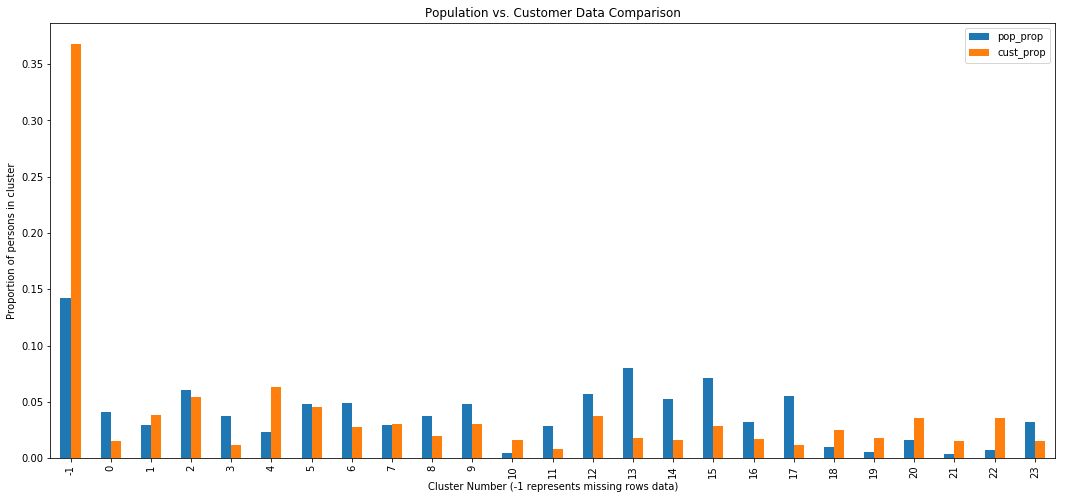

In [98]:
# Compare visually
pop_cust.plot(x='cluster', y=['pop_prop', 'cust_prop'], kind='bar', figsize=(18, 8))
plt.title('Population vs. Customer Data Comparison')
plt.xlabel('Cluster Number (-1 represents missing rows data)')
plt.ylabel('Proportion of persons in cluster')
plt.show()

In [99]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cc23 = kmeans.cluster_centers_[23]
cc23 = pd.Series(cc23)
cc23.sort_values(ascending=False, inplace=True)
cc23.head(5)

74    3.282993
1     2.859872
13    2.843436
14    2.391137
48    2.262287
dtype: float64

In [100]:
# Transform cluster 23 to original feature values
cc23 = scaler.inverse_transform(pca.inverse_transform(cc23))
cc23 = pd.Series(cc23).round()
cc23.index = customers_clean.columns
cc23

ALTERSKATEGORIE_GROB         3.0
ANREDE_KZ                   -0.0
FINANZ_MINIMALIST            3.0
FINANZ_SPARER                3.0
FINANZ_VORSORGER             3.0
FINANZ_ANLEGER               2.0
FINANZ_UNAUFFAELLIGER        2.0
FINANZ_HAUSBAUER             3.0
GREEN_AVANTGARDE             0.0
HEALTH_TYP                   3.0
RETOURTYP_BK_S               5.0
SEMIO_SOZ                    6.0
SEMIO_FAM                    5.0
SEMIO_REL                    4.0
SEMIO_MAT                    4.0
SEMIO_VERT                   6.0
SEMIO_LUST                   5.0
SEMIO_ERL                    4.0
SEMIO_KULT                   5.0
SEMIO_RAT                    3.0
SEMIO_KRIT                   4.0
SEMIO_DOM                    4.0
SEMIO_KAEM                   3.0
SEMIO_PFLICHT                3.0
SEMIO_TRADV                  4.0
SOHO_KZ                      0.0
VERS_TYP                     1.0
ANZ_PERSONEN                 2.0
ANZ_TITEL                    0.0
HH_EINKOMMEN_SCORE           4.0
          

In [101]:
# Analyze 2 top principal components of cluster 23
pca_results(customers_clean, pca, 74, 5, False)

GFK_URLAUBERTYP_9.0    0.3095
CAMEO_DEU_2015_3B      0.2651
GFK_URLAUBERTYP_7.0    0.2459
ZABEOTYP_4             0.1777
CAMEO_DEUG_2015_9      0.1695
CAMEO_DEU_2015_1B     -0.1798
CJT_GESAMTTYP_1.0     -0.1911
CAMEO_DEU_2015_5C     -0.2071
GFK_URLAUBERTYP_5.0   -0.2125
GFK_URLAUBERTYP_8.0   -0.2219
Name: 73, dtype: float64

In [102]:
pca_results(customers_clean, pca, 62, 5, False)

CJT_GESAMTTYP_4.0      0.3718
CAMEO_DEU_2015_5C      0.2100
FINANZTYP_1            0.1860
ZABEOTYP_4             0.1340
LP_STATUS_FEIN_3.0     0.1321
FINANZTYP_3           -0.1909
GEBAEUDETYP_1.0       -0.2194
GFK_URLAUBERTYP_4.0   -0.2897
CJT_GESAMTTYP_2.0     -0.3286
LP_STATUS_FEIN_2.0    -0.3494
Name: 61, dtype: float64

In [103]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cc1 = kmeans.cluster_centers_[1]
cc1 = pd.Series(cc1)
cc1.sort_values(ascending=False, inplace=True)
cc1.head(5)

63    6.717833
62    6.693689
70    5.199352
72    5.096799
50    3.499280
dtype: float64

In [104]:
cc1 = scaler.inverse_transform(pca.inverse_transform(cc1))
cc1 = pd.Series(cc1).round()
cc1.index = customers_clean.columns
cc1

ALTERSKATEGORIE_GROB         3.0
ANREDE_KZ                   -0.0
FINANZ_MINIMALIST            3.0
FINANZ_SPARER                2.0
FINANZ_VORSORGER             4.0
FINANZ_ANLEGER               1.0
FINANZ_UNAUFFAELLIGER        2.0
FINANZ_HAUSBAUER             3.0
GREEN_AVANTGARDE             1.0
HEALTH_TYP                   3.0
RETOURTYP_BK_S               6.0
SEMIO_SOZ                    8.0
SEMIO_FAM                    6.0
SEMIO_REL                    3.0
SEMIO_MAT                    4.0
SEMIO_VERT                   7.0
SEMIO_LUST                   6.0
SEMIO_ERL                    4.0
SEMIO_KULT                   6.0
SEMIO_RAT                    2.0
SEMIO_KRIT                   4.0
SEMIO_DOM                    4.0
SEMIO_KAEM                   3.0
SEMIO_PFLICHT                3.0
SEMIO_TRADV                  3.0
SOHO_KZ                      0.0
VERS_TYP                     1.0
ANZ_PERSONEN                 1.0
ANZ_TITEL                    0.0
HH_EINKOMMEN_SCORE           5.0
          

In [105]:
# Analyze 2 top principal components of cluster 1
pca_results(customers_clean, pca, 74, 5, False)

GFK_URLAUBERTYP_9.0    0.3095
CAMEO_DEU_2015_3B      0.2651
GFK_URLAUBERTYP_7.0    0.2459
ZABEOTYP_4             0.1777
CAMEO_DEUG_2015_9      0.1695
CAMEO_DEU_2015_1B     -0.1798
CJT_GESAMTTYP_1.0     -0.1911
CAMEO_DEU_2015_5C     -0.2071
GFK_URLAUBERTYP_5.0   -0.2125
GFK_URLAUBERTYP_8.0   -0.2219
Name: 73, dtype: float64

In [106]:
pca_results(customers_clean, pca, 57, 5, False)

GFK_URLAUBERTYP_11.0    0.3187
FINANZTYP_6             0.2384
ZABEOTYP_3              0.1743
GEBAEUDETYP_8.0         0.1568
CAMEO_DEUG_2015_7       0.1444
GFK_URLAUBERTYP_4.0    -0.1742
CJT_GESAMTTYP_4.0      -0.1959
LP_STATUS_FEIN_6.0     -0.1980
CJT_GESAMTTYP_2.0      -0.2826
ZABEOTYP_2             -0.3006
Name: 56, dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data

Characteristics of customers popular to company include the more tradional and conservative older generation that live in less dense households.

The opposite which captures a younger, less conservative and tradional generation are less popular with the company.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [107]:
#References

#https://ksatola.github.io/projects/Identify_Customer_Segments10new_final.html